# Modelling

## Packages

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)
    return(smote_x, smote_y)


def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
#remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']
#remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'rs', 'lema_diff', 'long_sema_slope']
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'rs']

In [4]:
#train_files = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']
train_files = ['2016', '2017', '2018', '2019']
#train_files = ['2019']
df = pd.DataFrame()

for i, train_file in enumerate(train_files): 
    
    train_data = 'data/yearly_tick_data/tab_'+ train_file +'.csv'
    df1 = pd.read_csv(train_data)
    df = df.append(df1)
    df = df.reset_index(drop=True)

df.drop(remove_cols, axis=1, inplace=True)
print(len(df))
df.head(5)

405839


,spread_avg,tick_sd,sema_diff,lema_diff,diff,avg_gain,avg_loss,rsi,ssma_diff,lsma_diff,sma_diff,max_gap,min_gap,ema_diff,small_sema_slope,long_sema_slope,slope_diff,direction
0,0.00003,0.00014,-0.00015,-0.00013,-0.00028,0.00005,0.00021,20.82725,-0.00004,-0.00017,-0.00003,0.00072,0.00000,-0.00006,14.80289,-84.88791,99.69079,same
1,0.00003,0.00017,-0.00006,-0.00006,0.00013,0.00006,0.00021,23.58349,-0.00006,-0.00007,-0.00002,0.00059,-0.00013,-0.00007,-77.20509,-82.37683,5.17174,decrease
2,0.00003,0.00016,-0.00022,-0.00015,-0.00047,0.00006,0.00023,21.63284,-0.00015,-0.00012,-0.00005,0.00107,0.00000,-0.00014,-85.26975,-79.15413,-6.11562,decrease
3,0.00003,0.00006,-0.00020,-0.00012,-0.00008,0.00006,0.00024,20.82396,-0.00023,-0.00007,-0.00022,0.00071,0.00000,-0.00022,-86.33934,-79.32615,-7.01318,same
4,0.00004,0.00008,-0.00008,-0.00008,0.00008,0.00007,0.00022,23.73546,-0.00013,-0.00004,-0.00030,0.00048,-0.00008,-0.00022,-86.31234,-81.81480,-4.49754,decrease


In [5]:
%%time
target_col = 'direction'
x = df.loc[:, df.columns != target_col]
y = df[target_col]

#x, y = smote_data(x, y)

train_x, valid_x, train_y, valid_y = train_test_split(x, y,train_size = 0.8,random_state = 1)

Wall time: 322 ms


%%time
alg = xgboost.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
clf_xg = GridSearchCV(alg,
                      {'max_depth': [4],
                       'n_estimators': [100],
                       'learning_rate': [0.1]
                      },
                      verbose=2,
                      scoring='neg_log_loss',
                      n_jobs = -1)


clf_xg.fit(train_x, train_y)

print(clf_xg.best_score_, clf_xg.best_params_)

joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))

In [9]:
%%time
clf_xg = xgboost.XGBClassifier(tree_method='gpu_hist', gpu_id=0)

clf_xg.fit(train_x, train_y)
joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))
print(json.dumps(clf_xg.get_xgb_params(), indent = 2))

[21:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    decrease       0.68      0.47      0.56     11904
    increase       0.69      0.48      0.56     11995
        same       0.81      0.91      0.86     57269

    accuracy                           0.78     81168
   macro avg       0.73      0.62      0.66     81168
weighted avg       0.77      0.78      0.77     81168

{
  "objective": "multi:softprob",
  "base_score": 0.5,
  "booster": "gbtree",
  "colsample_bylevel": 1,
  "colsample_bynode": 1,
  "colsample_bytree": 1,
  "gamma": 0,
  "gpu_id": 0,
  "interaction_constraints": "",
  "learning_rate": 0.300000012,
  "max_delta_step": 0,
  "max_depth": 6,
  "min_child_weigh

In [7]:
kfold = KFold(n_splits=10, random_state=7)

In [10]:
results = cross_val_score(clf_xg, train_x, train_y, cv=kfold)

[21:13:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [11]:
results

array([0.78394111, 0.78889334, 0.78492007, 0.78615209, 0.78787692,
       0.78344165, 0.7863061 , 0.77952998, 0.78110081, 0.78784612])

In [8]:
%%time
clf_xg = xgboost.XGBClassifier(tree_method='gpu_hist', gpu_id=0)

clf_xg.fit(train_x, train_y)
joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))
print(json.dumps(clf_xg.get_xgb_params(), indent = 2))

[21:12:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    decrease       0.68      0.47      0.56     11904
    increase       0.69      0.48      0.56     11995
        same       0.81      0.91      0.86     57269

    accuracy                           0.78     81168
   macro avg       0.73      0.62      0.66     81168
weighted avg       0.77      0.78      0.77     81168

{
  "objective": "multi:softprob",
  "base_score": 0.5,
  "booster": "gbtree",
  "colsample_bylevel": 1,
  "colsample_bynode": 1,
  "colsample_bytree": 1,
  "gamma": 0,
  "gpu_id": 0,
  "interaction_constraints": "",
  "learning_rate": 0.300000012,
  "max_delta_step": 0,
  "max_depth": 6,
  "min_child_weigh

## -----------------------------------

<AxesSubplot:>

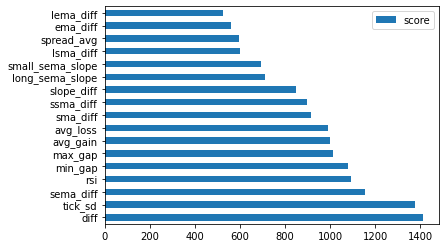

In [13]:
feature_important = clf_xg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

              precision    recall  f1-score   support

    decrease       0.71      0.52      0.60     17681
    increase       0.71      0.52      0.60     17288
        same       0.73      0.86      0.79     51848

    accuracy                           0.73     86817
   macro avg       0.72      0.63      0.66     86817
weighted avg       0.72      0.73      0.71     86817

Wall time: 2.38 s


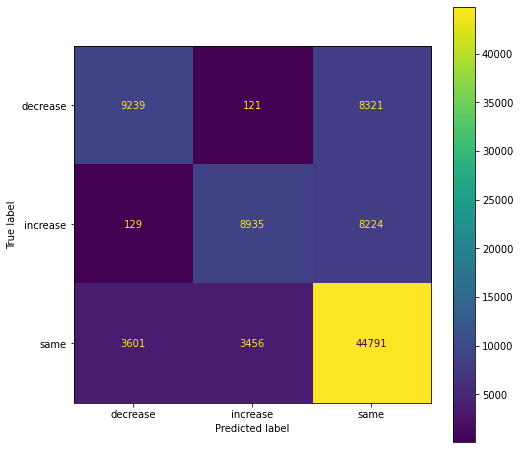

In [14]:
%%time
test_file = '2018'
test_data = 'data/yearly_tick_data/tab_'+ test_file +'.csv'

df1 = pd.read_csv(test_data)
df1.drop(remove_cols, axis=1, inplace=True)
x = df1.loc[:, df1.columns != target_col]
y = df1[target_col]

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x)

df1['predictions'] = predictions

print(classification_report(y, predictions))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y, predictions, labels=clf_xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xg.classes_)
disp.plot(ax=ax)

              precision    recall  f1-score   support

    decrease       0.70      0.50      0.58     21180
    increase       0.70      0.48      0.57     21565
        same       0.73      0.87      0.79     66455

    accuracy                           0.72    109200
   macro avg       0.71      0.61      0.65    109200
weighted avg       0.72      0.72      0.71    109200

Wall time: 3.7 s


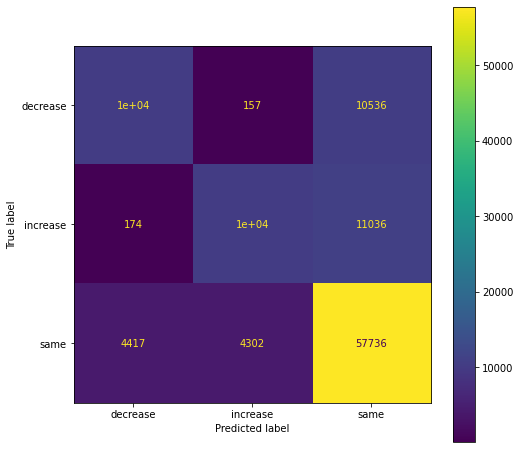

In [15]:
%%time
test_file = '2020'
test_data = 'data/yearly_tick_data/tab_'+ test_file +'.csv'

df1 = pd.read_csv(test_data)
df1 = df1.round(5)
df1.drop(remove_cols, axis=1, inplace=True)
x = df1.loc[:, df1.columns != target_col]
y = df1[target_col]

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x)

df1['predictions'] = predictions

print(classification_report(y, predictions))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y, predictions, labels=clf_xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xg.classes_)
disp.plot(ax=ax)

In [10]:
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)